In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
import numpy as np
import math
import scipy.stats.stats as stats
import pyodbc
import seaborn as seab

In [143]:
# 获取数据 10000条   
# https://blog.csdn.net/jin_tmac/article/details/78949643
# https://blog.csdn.net/PbGc396Dwxjb77F2je/article/details/78786994
# https://edu.hellobi.com/course/265/lessons
host='tianxibigdata.database.chinacloudapi.cn'
port='1433'
user='tianxi'
password='1qa2ws!QA'
database='TianxiBigData'
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+host+';DATABASE='+database+';UID='+user+';PWD='+password)
data = pd.read_sql("select top 10000  CreditRatings,Age,Income,OverdueNo90,AuthorizedAmounts,createtime from creditrating",conn)
conn.close()

In [144]:
# 数据清洗
# 数据类型转换
data[['Age','Income','OverdueNo90','AuthorizedAmounts']] = data[['Age','Income','OverdueNo90','AuthorizedAmounts']].astype(float)
# 数据打标签
def getLabel(x):
    return 0 if x == '' else 1
data['label'] = data['CreditRatings'].apply(getLabel)
# 查看数据分布情况
data.describe(include='all').to_csv('dataDescribe.csv')
# 查看箱形图 箱形图根据分位数粗略查看异常值
# dataBox = data[['Age','Income','OverdueNo90','AuthorizedAmounts','label']]
# dataBox.boxplot(figsize=(10,6))
# plt.show()
# 根据分布情况删除异常值(包括不合实际值，如年龄200岁，收入小于0等)，填补缺失值  省略...
columns = ['Age','Income','OverdueNo90','AuthorizedAmounts'] 
for x in columns:
    min = data[x].quantile(0.25) - 1.5 * (data[x].quantile(0.75) - data[x].quantile(0.25))
    max = data[x].quantile(0.75) + 1.5 * (data[x].quantile(0.75) - data[x].quantile(0.25))
    data[x] = data[data[x]<max][data[x]>min][x]
sumZheng = data[data['label']==1]['label'].count()
sumFu = data[data['label']==0]['label'].count()
print('正例：',sumZheng,' 负例：',sumFu)
#根据正负样本比例进行 抽样(根据效果查找合适比例)
data = pd.concat([data,data[data['label']==0].sample(n=3000,replace=True)],ignore_index=True)  
sumZheng = data[data['label']==1]['label'].count()
sumFu = data[data['label']==0]['label'].count()
print('正例：',sumZheng,' 负例：',sumFu)
data.head()


正例： 8828  负例： 1172
正例： 8828  负例： 4172


,CreditRatings,Age,Income,OverdueNo90,AuthorizedAmounts,createtime,label
0,C,41.0,12083.0,3.0,48785.0,2018-06-01 03:37:10.207,1
1,,45.0,42689.0,6.0,34051.0,2018-06-04 03:37:10.393,0
2,B,29.0,7984.0,1.0,16324.0,2018-06-04 03:37:10.410,1
3,B,58.0,34686.0,1.0,40699.0,2018-06-04 03:37:10.503,1
4,D,98.0,22148.0,5.0,8229.0,2018-06-04 03:37:10.660,1


决策树分箱--> [69.5, 76.5, 86.5, 91.5]
woeDecision--> [-0.001, -0.07, -0.158, -0.034, 0.179, 0.047]
ivDecision--> 0.008253381541400285


c:\users\administrator\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:75: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)


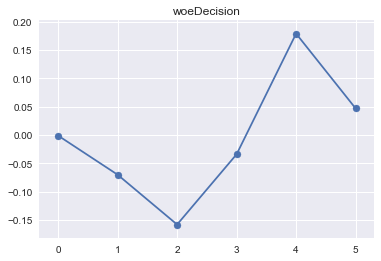

                 min   max   sum  total      rate       woe  goodattribute  \
Bucket                                                                       
(17.999, 46.0]  18.0  46.0  2978   4450  0.669213 -0.044903       0.337336   
(46.0, 74.0]    47.0  74.0  2917   4310  0.676798 -0.010437       0.330426   
(74.0, 99.0]    75.0  99.0  2933   4240  0.691745  0.058758       0.332238   

                badattribute  
Bucket                        
(17.999, 46.0]      0.352828  
(46.0, 74.0]        0.333893  
(74.0, 99.0]        0.313279  
woex1--》 [-0.045, -0.01, 0.059]
ivx1--> 0.001845867880850135


c:\users\administrator\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)


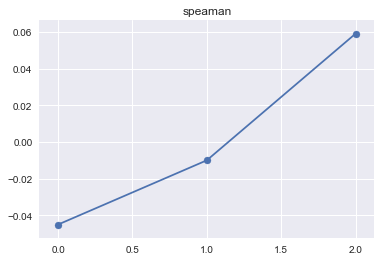

ivAge--> 0.008253381541400285


c:\users\administrator\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:75: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)


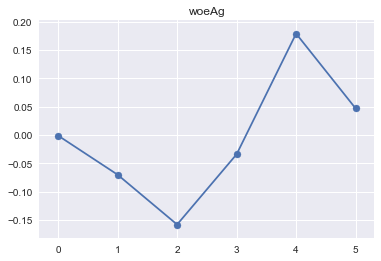

In [147]:
# 对年龄特征分组 手动分组，或者根据相关性分组,分组需要不断调整到优化值，然后计算woe及iv值判断分组   woe单调，iv值0.02-0.1对分类弱价值,0.1-0.3中价值
def spearmanr_bin(Y, X, n = 20):
    r = 0
    good=Y.sum()
    bad=Y.count()-good
    while np.abs(r) < 1:
        d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.qcut(X, n)})
        d2 = d1.groupby('Bucket', as_index = True)
        r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
        n = n - 1
    d3 = pd.DataFrame(d2.X.min(), columns = ['min'])
    d3['min']=d2.min().X
    d3['max'] = d2.max().X
    d3['sum'] = d2.sum().Y
    d3['total'] = d2.count().Y
    d3['rate'] = d2.mean().Y
    d3['woe']=np.log((d3['rate']/(1-d3['rate']))/(good/bad))
    d3['goodattribute']=d3['sum']/good
    d3['badattribute']=(d3['total']-d3['sum'])/bad
    iv=((d3['goodattribute']-d3['badattribute'])*d3['woe']).sum()
    d4 = (d3.sort_index(by = 'min'))
    print("=" * 60)
    print(d4)
    cut=[]
    cut.append(float('-inf'))
    for i in range(1,n+1):
        qua=X.quantile(i/(n+1))
        cut.append(round(qua,4))
    cut.append(float('inf'))
    woe=list(d4['woe'].round(3))
    return d4,iv,cut,woe
# 决策树分箱
import sklearn.tree as tree
def decession_tree_bin(X,y):
    clf=tree.DecisionTreeClassifier(criterion = 'entropy',
                                    max_leaf_nodes= 5,
                                    min_samples_leaf = 0.05).fit(X,y)

    # basic output
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    threshold = clf.tree_.threshold
    boundary = []
    for i in range(n_nodes):
        if children_left[i]!=children_right[i]:
            boundary.append(threshold[i])
    sort_boundary = sorted(boundary)
    return sort_boundary
decisionCut = decession_tree_bin(data['Age'].values.reshape(-1,1),data['label'].values.reshape(-1,1))
print('决策树分箱-->', decisionCut)
dfDecision,ivDecision,woeDecision = self_bin(data.label,data.Age,cutAge)
print('woeDecision-->',woeDecision)
print('ivDecision-->',ivDecision)
plt.plot(woeDecision)
plt.title('woeDecision')
plt.scatter(range(len(woeDecision)),woeDecision)
plt.show()
#自定义分箱函数
def self_bin(Y,X,cat):
    good=Y.sum()
    bad=Y.count()-good
    d1=pd.DataFrame({'X':X,'Y':Y,'Bucket':pd.cut(X,cat)})
    d2=d1.groupby('Bucket', as_index = True)
    d3 = pd.DataFrame(d2.X.min(), columns=['min'])
    d3['min'] = d2.min().X
    d3['max'] = d2.max().X
    d3['sum'] = d2.sum().Y
    d3['total'] = d2.count().Y
    d3['rate'] = d2.mean().Y
    d3['woe'] = np.log((d3['rate'] / (1 - d3['rate'])) / (good / bad))
    d3['goodattribute'] = d3['sum'] / good
    d3['badattribute'] = (d3['total'] - d3['sum']) / bad
    iv = ((d3['goodattribute'] - d3['badattribute']) * d3['woe']).sum()
    d4 = (d3.sort_index(by='min'))
    print("=" * 60)
#     print(d4)
    woe = list(d4['woe'].round(3))
    return d4, iv,woe
dfx1, ivx1,cutx1,woex1=spearmanr_bin(data.label,data.Age,n=10)
print('woex1--》',woex1)
print('ivx1-->',ivx1)
plt.plot(woex1)
plt.title('speaman')
plt.scatter(range(len(woex1)),woex1)
plt.show()

cutAge = [0,30,45,55,65,75,100]
dfAge,ivAge,woeAge = self_bin(data.label,data.Age,cutAge)
print('ivAge-->',ivAge)
plt.plot(woeAge)
plt.title('woeAg')
plt.scatter(range(len(woeAge)),woeAge)
plt.show()



In [111]:
#替换分箱数据
def getAgeLevel(x):
    i = 0
    while x>cutAge[i]:
        i += 1
    return str(i)
print(data['Age'].head())
data['Age'] = data['Age'].apply(getAgeLevel)
print(data['Age'].head())
# 对分组数据Onehot编码
dummy = pd.get_dummies(data.drop('CreditRatings',axis=1),dtype=float)
dummy.head() 

,Income,OverdueNo90,AuthorizedAmounts,createtime,label,Age_1,Age_10,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9
0,12083.0,3.0,48785.0,2018-06-01 03:37:10.207,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,42689.0,6.0,34051.0,2018-06-04 03:37:10.393,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,7984.0,1.0,16324.0,2018-06-04 03:37:10.410,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34686.0,1.0,40699.0,2018-06-04 03:37:10.503,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,22148.0,5.0,8229.0,2018-06-04 03:37:10.660,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


     Income  OverdueNo90  AuthorizedAmounts              createtime  label  \
0  0.233853     0.500000           0.975590 2018-06-01 03:37:10.207      1   
1  0.852356     1.000000           0.677855 2018-06-04 03:37:10.393      0   
2  0.151019     0.166667           0.319640 2018-06-04 03:37:10.410      1   
3  0.690627     0.166667           0.812193 2018-06-04 03:37:10.503      1   
4  0.437252     0.833333           0.156061 2018-06-04 03:37:10.660      1   

   Age_1  Age_10  Age_2  Age_3  Age_4  Age_5  Age_6  Age_7  Age_8  Age_9  
0    0.0     0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0  
1    0.0     0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0  
2    1.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0     0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0  
4    0.0     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  


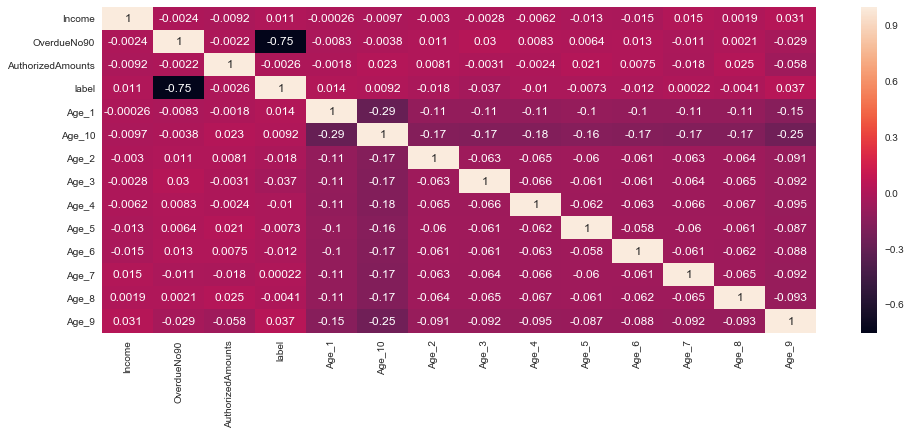

In [116]:
# 特征归一化
data = dummy
from sklearn.preprocessing import MinMaxScaler
for x in columns:
    if x == 'Age':
        continue
    data[x] = MinMaxScaler().fit_transform(data[x].values.reshape(-1,1))[:,0]
print(data.head())

# 特征降维，特征较少，不降维了
seab.set()
plt.figure(figsize=(16,6))
seab.heatmap(data.corr(),annot=True)
plt.show()
from sklearn.decomposition import PCA
def jiangWei(ld_n,df):
    return PCA(n_components=ld_n).fit_transform(df.values)

In [ ]:
# 设基准比率对应分值600，二倍基准比率PDO对应分值20
A = 600 - 
B = 20 / np.log(2)
oddsi = model.predict
score = A - B * np.log(odds)